# Runtime Setup

In [1]:
%load_ext autoreload
%autoreload 2

# Path Setup

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
%cd /content/drive/MyDrive/Food\ Property\ Prediction

/content/drive/.shortcut-targets-by-id/1NHIP6dsL48pqUUNtIIzE2uvoxLxp5LcH/Food Property Prediction


In [5]:
!pwd

/content/drive/.shortcut-targets-by-id/1NHIP6dsL48pqUUNtIIzE2uvoxLxp5LcH/Food Property Prediction


# Load Dataset

In [6]:
from src.dataset import FoodPredictionDataset
from matplotlib import pyplot as plt

In [7]:
food_dataset = FoodPredictionDataset(root_dir="ECUSTFD-resized-", mode="train")

In [47]:
test_dataset = FoodPredictionDataset(root_dir="ECUSTFD-resized-",mode="test")

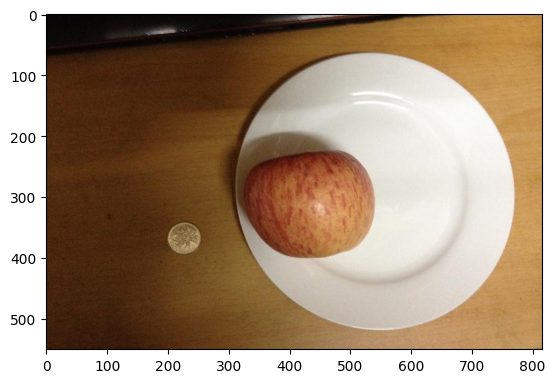

[326.0, 229.0, 540.0, 401.0]
310
ECUSTFD-resized-/JPEGImages/apple001S(1).JPG
551
816
apple001S(1)
0


In [8]:
for i in range(len(food_dataset)):
    sample = food_dataset[i]
    plt.imshow(sample['image'])
    plt.show()
    print(sample['boundingBox'])
    print(sample['volume'])
    print(sample['filename'])
    print(sample['height'])
    print(sample['width'])
    print(sample['image_id'])
    print(sample['category_id'])
    break

# DataLoader

In [9]:
from torch.utils.data import DataLoader

In [10]:
dataloader = DataLoader(food_dataset, batch_size=4, shuffle=True, num_workers=0)

In [11]:
for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched['volume'])
    break

tensor([150,  30, 450, 130])


# Object Detection & Segmentation

In [12]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-g6yhso5m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-g6yhso5m
  Resolved https://github.com/facebookresearch/detectron2.git to commit a0e22dbfa791e6235e4f196d5ce25e754d02be31
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50

In [13]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import numpy as np
from detectron2 import model_zoo
from google.colab.patches import cv2_imshow
# Some basic setup:
# Setup detectron2 logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
import os
from detectron2.structures import BoxMode

In [14]:
def getDataSetDicts(mode):
  if(mode=='TRAIN'):
    food_dataset = FoodPredictionDataset(root_dir="ECUSTFD-resized-", mode="train")
  elif(mode=='VAL'):
    food_dataset = FoodPredictionDataset(root_dir="ECUSTFD-resized-", mode="val")
  datasetDict=[]
  for image in food_dataset:
    record={}
    record['file_name']=image['filename']
    record['image_id']=image['image_id']
    record['height']=image['height']
    record['width']=image['width']
    record['annotations']=[]
    annotationObj={}
    annotationObj['bbox']=image['boundingBox']
    annotationObj['bbox_mode']=BoxMode.XYXY_ABS
    annotationObj['category_id']=image['category_id']
    #annotationObj['segmentation']=image['segmentation']
    annotationObj['iscrowd']=0
    record['annotations'].append(annotationObj)
    datasetDict.append(record)
  return datasetDict

In [15]:
trainData = getDataSetDicts('TRAIN')
testData = getDataSetDicts('VAL')
print(trainData[0])
print(testData[0])

{'file_name': 'ECUSTFD-resized-/JPEGImages/apple001S(1).JPG', 'image_id': 'apple001S(1)', 'height': 551, 'width': 816, 'annotations': [{'bbox': [326.0, 229.0, 540.0, 401.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}]}
{'file_name': 'ECUSTFD-resized-/JPEGImages/apple002S(2).JPG', 'image_id': 'apple002S(2)', 'height': 612, 'width': 816, 'annotations': [{'bbox': [64.0, 195.0, 439.0, 530.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}]}


In [16]:
trainData[300]

{'file_name': 'ECUSTFD-resized-/JPEGImages/mango003S(6).JPG',
 'image_id': 'mango003S(6)',
 'height': 612,
 'width': 816,
 'annotations': [{'bbox': [455.0, 308.0, 710.0, 463.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 10,
   'iscrowd': 0}]}

In [17]:
#DatasetCatalog.remove("food_train")
#DatasetCatalog.remove("food_val")
#MetadataCatalog.remove("food_train")
#MetadataCatalog.remove("food_val")

KeyError: ignored

In [18]:
def getDataSet():
  ...
  return trainData

def getValData():
  ...
  return testData
#DatasetCatalog.remove("food_train")
#DatasetCatalog.remove("food_val")
#MetadataCatalog.remove("food_train")
#MetadataCatalog.remove("food_val")
DatasetCatalog.register("food_train", getDataSet)
DatasetCatalog.register("food_val",getValData)

In [19]:
traindata1 = DatasetCatalog.get("food_train")
valdata1 = DatasetCatalog.get("food_val")

In [20]:
classes=[x for x in food_dataset.sheet_names]
classes

['apple',
 'banana',
 'bread',
 'bun',
 'doughnut',
 'egg',
 'fired_dough_twist',
 'grape',
 'lemon',
 'litchi',
 'mango',
 'mooncake',
 'orange',
 'pear',
 'peach',
 'plum',
 'qiwi',
 'sachima',
 'tomato']

In [21]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("food_train").set(thing_classes=classes)
MetadataCatalog.get("food_val").set(thing_classes=classes)
trainMetadata=MetadataCatalog.get("food_train")
testMetadata=MetadataCatalog.get("food_val")

{'file_name': 'ECUSTFD-resized-/JPEGImages/orange008T(22).JPG', 'image_id': 'orange008T(22)', 'height': 612, 'width': 816, 'annotations': [{'bbox': [409.0, 233.0, 655.0, 455.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 12, 'iscrowd': 0}]}


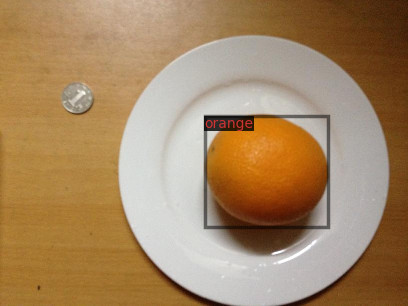

{'file_name': 'ECUSTFD-resized-/JPEGImages/doughnut005T(7).JPG', 'image_id': 'doughnut005T(7)', 'height': 612, 'width': 816, 'annotations': [{'bbox': [357.0, 203.0, 625.0, 462.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}]}


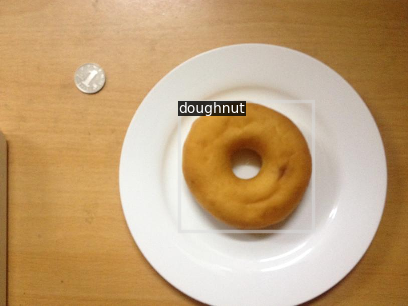

{'file_name': 'ECUSTFD-resized-/JPEGImages/bread002S(3).JPG', 'image_id': 'bread002S(3)', 'height': 612, 'width': 816, 'annotations': [{'bbox': [21.0, 312.0, 492.0, 422.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}]}


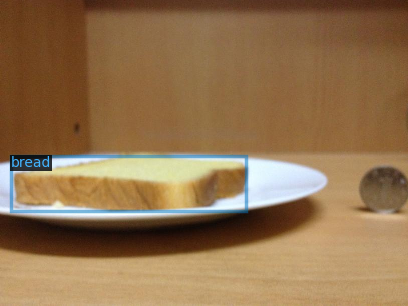

In [22]:
for d in random.sample(traindata1, 3):
  print(d)
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=trainMetadata, scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

{'file_name': 'ECUSTFD-resized-/JPEGImages/orange005S(1).JPG', 'image_id': 'orange005S(1)', 'height': 612, 'width': 816, 'annotations': [{'bbox': [215.0, 251.0, 463.0, 491.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 12, 'iscrowd': 0}]}


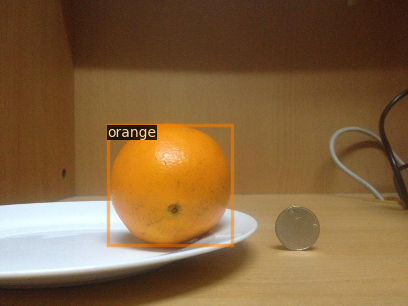

{'file_name': 'ECUSTFD-resized-/JPEGImages/qiwi005S(4).JPG', 'image_id': 'qiwi005S(4)', 'height': 612, 'width': 816, 'annotations': [{'bbox': [464.0, 243.0, 635.0, 370.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 16, 'iscrowd': 0}]}


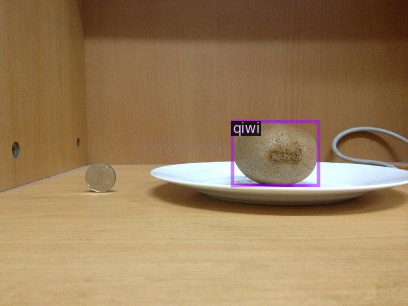

{'file_name': 'ECUSTFD-resized-/JPEGImages/apple013S(3).JPG', 'image_id': 'apple013S(3)', 'height': 612, 'width': 816, 'annotations': [{'bbox': [447.0, 208.0, 634.0, 383.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}]}


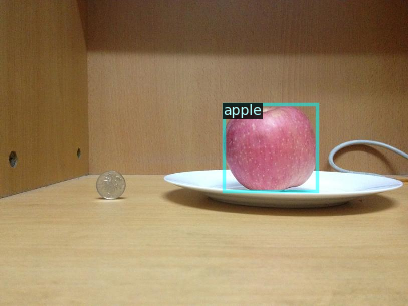

In [23]:
for d in random.sample(valdata1, 3):
  print(d)
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=trainMetadata, scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

In [24]:
import torch
torch.cuda.empty_cache()

In [25]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("food_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00225  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 19  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/09 23:11:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 135MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/09 23:11:01 d2.engine.train_loop]: Starting training from iteration 0
[12/09 23:11:21 d2.utils.events]:  eta: 0:19:24  iter: 19  total_loss: 3.419  loss_cls: 2.859  loss_box_reg: 0.573  loss_rpn_cls: 0.003799  loss_rpn_loc: 0.001762    time: 0.7579  last_time: 0.7999  data_time: 0.0474  last_data_time: 0.0104   lr: 4.4957e-05  max_mem: 4017M
[12/09 23:11:40 d2.utils.events]:  eta: 0:19:29  iter: 39  total_loss: 2.108  loss_cls: 1.45  loss_box_reg: 0.5873  loss_rpn_cls: 0.003519  loss_rpn_loc: 0.002121    time: 0.7706  last_time: 0.7506  data_time: 0.0336  last_data_time: 0.0607   lr: 8.9912e-05  max_mem: 4017M
[12/09 23:11:55 d2.utils.events]:  eta: 0:19:12  iter: 59  total_loss: 1.228  loss_cls: 0.6531  loss_box_reg: 0.5766  loss_rpn_cls: 0.002008  loss_rpn_loc: 0.001889    time: 0.7683  last_time: 0.8049  data_time: 0.0331  last_data_time: 0.0878   lr: 0.00013487  max_mem: 4019M
[12/09 23:12:13 d2.utils.events]:  eta: 0:19:04  iter: 79  total_loss: 1.261  loss_cls: 0.6099  loss_b

In [26]:
print(cfg.OUTPUT_DIR)
cfg.MODEL.WEIGHTS = os.path.join("output/", "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

./output
[12/09 23:32:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...


In [27]:
metadata = MetadataCatalog.get("food_val").set()
dataset_dicts = metadata.get("dataset_dicts")
print(testData[0]["annotations"])

[{'bbox': [64.0, 195.0, 439.0, 530.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}]


In [28]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("food_val",cfg,False,output_dir='./output')

WARNING [12/09 23:32:54 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/09 23:32:54 d2.evaluation.coco_evaluation]: Trying to convert 'food_val' to COCO format ...
WARNING [12/09 23:32:54 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/food_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.


In [29]:
val_loader = build_detection_test_loader(cfg, "food_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[12/09 23:33:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/09 23:33:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/09 23:33:02 d2.data.common]: Serializing 599 elements to byte tensors and concatenating them all ...
[12/09 23:33:02 d2.data.common]: Serialized dataset takes 0.16 MiB
[12/09 23:33:02 d2.evaluation.evaluator]: Start inference on 599 batches
[12/09 23:33:04 d2.evaluation.evaluator]: Inference done 11/599. Dataloading: 0.0015 s/iter. Inference: 0.1036 s/iter. Eval: 0.0002 s/iter. Total: 0.1053 s/iter. ETA=0:01:01
[12/09 23:33:09 d2.evaluation.evaluator]: Inference done 58/599. Dataloading: 0.0022 s/iter. Inference: 0.1039 s/iter. Eval: 0.0003 s/iter. Total: 0.1064 s/iter. ETA=0:00:57
[12/09 23:33:14 d2.evaluation.evaluator]: Inference done 102/599. Dataloading: 0.0034 s/iter. Inference: 0.106

{'instances': Instances(num_instances=1, image_height=612, image_width=816, fields=[pred_boxes: Boxes(tensor([[320.1366, 249.4400, 475.8660, 423.7325]], device='cuda:0')), scores: tensor([0.9413], device='cuda:0'), pred_classes: tensor([16], device='cuda:0')])}


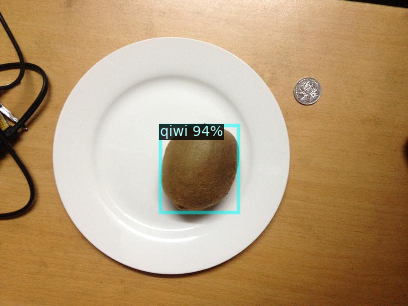

{'instances': Instances(num_instances=1, image_height=612, image_width=816, fields=[pred_boxes: Boxes(tensor([[421.8661, 288.7932, 779.2994, 447.1120]], device='cuda:0')), scores: tensor([0.9778], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


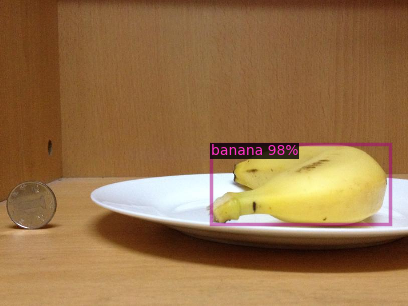

In [30]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(valdata1, 2):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=testMetadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

ECUSTFD-resized-/JPEGImages/banana015S(7).JPG


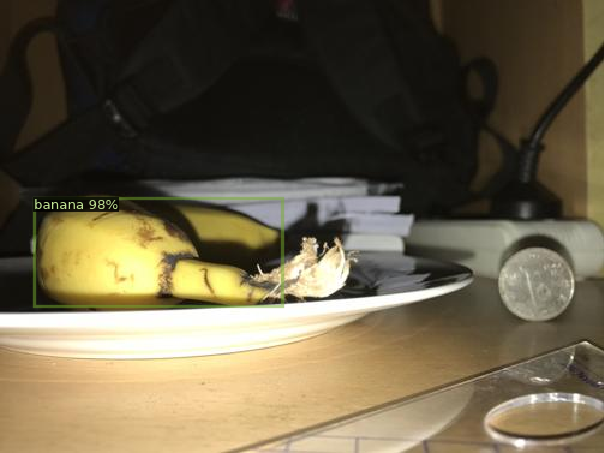

{'instances': Instances(num_instances=1, image_height=378, image_width=504, fields=[pred_boxes: Boxes(tensor([[ 28.1577, 165.7271, 234.6835, 255.3673]], device='cuda:0')), scores: tensor([0.9798], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


In [53]:
from google.colab.patches import cv2_imshow
f=test_dataset[250]['filename']
print(f)
image = cv2.imread(f)
outputs = predictor(image)
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])
print(outputs)